In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import models

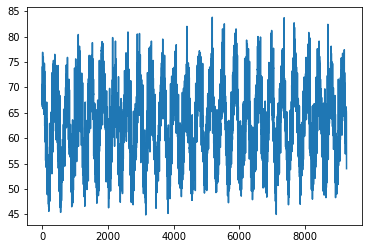

In [2]:
import polar_pla as pla
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# read in time series into temporary list
temp = []
originalData = []
f = open('DataSets/CTtemp.csv', 'r')
for line in f:
    originalData.append(float(line))
    temp.append(float(line))

plt.plot(originalData)

/usr/local/lib/python3.9/site-packages/PiecewiseLinearSegmentation/bottomup.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ( p, residuals, rank, s ) = lstsq( X, y )


217.31578291056292


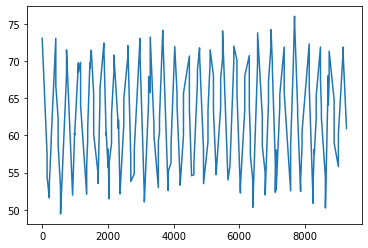

217.31578291056292


In [3]:
# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp, 1000)

In [4]:
seq_length = 6
train_proportion = 0.8



seq_length*=2
def sliding_window(data):
    inputs = []
    outputs = []
    input_numpy = []
    out_numpy = []
    for i in range(0, len(data)-seq_length, 2):
        #inputs.append(data[i:(i+seq_length)]) # the next n are the input
        #outputs.append(data[i+seq_length:i+seq_length+2]) # and the one after that is the output
        input_numpy.append(np.array(data[i:(i+seq_length)]).reshape(int(seq_length/2),2))
        out_numpy.append(np.array(data[i+seq_length:i+seq_length+1]))
        
    return Variable(torch.Tensor(input_numpy)), Variable(torch.Tensor(out_numpy))

# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)

trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [29]:
epochs = 1000
learning_rate = 0.0001
num_classes = 1
input_size = 2
hidden_size = 64
num_layers = 1

model = models.BiLSTM(num_classes, input_size, hidden_size, num_layers)

Epoch: 0/1000, loss: 0.016314370557665825
Epoch: 100/1000, loss: 0.005812967661768198
Epoch: 200/1000, loss: 0.005034723784774542
Epoch: 300/1000, loss: 0.003943470306694508
Epoch: 400/1000, loss: 0.0024890548083931208
Epoch: 500/1000, loss: 0.0014208998763933778
Epoch: 600/1000, loss: 0.001005395082756877
Epoch: 700/1000, loss: 0.0008745779632590711
Epoch: 800/1000, loss: 0.0008159034769050777
Epoch: 900/1000, loss: 0.0007789095398038626
Epoch: 1000/1000, loss: 0.0007533160969614983


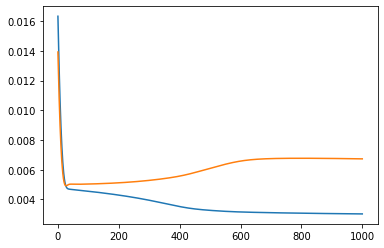

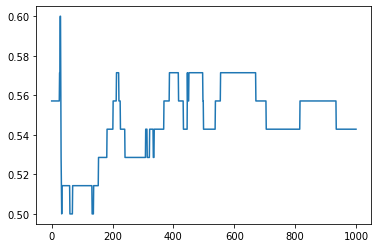

Lowest validation loss: 0.004918694496154785 at epoch 27


In [30]:
import torch.optim as optim
train_loss = []
validation_loss = []
epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

    # this is the validation part, ideally we wouldn't do this every epoch, but it's easy and
    # gives good insight into when the model overfits
    for i, (trainX, trainY) in enumerate(testset):
        model.zero_grad()
        output = model(trainX)  # get a prediction from the model
        loss = F.mse_loss(output, trainY)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(testset)
    
    if epoch_total_trainloss < min_val_loss:
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch

    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    for i, (trainX, trainY) in enumerate(trainset):  # for each batch

        model.zero_grad()
        output = model(trainX)  # get a prediction from the model
        loss = F.mse_loss(output, trainY)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch

    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    cnt=0
    for i, (trainX, trainY) in enumerate(trainset):
        output = model(trainX)
        cnt+=len(output)
        for x in range(len(output)):

            if output[x]>0 and trainY[x]>0 or output[x]<0 and trainY[x]<0:
                correct+=1 
            #print(output[0],labels[0])
    validation_direction_accuracy.append(correct/cnt)

    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")